<h1>Aikasarjat: Oluen tuotantomääriä</h1>

In [1]:
#Tuon ohjelmakirjastot
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Tiedoston avaaminen
df = pd.read_csv('http://taanila.fi/beer.csv')

#Aikaleimat indeksiin
df.index = pd.to_datetime(df['Month'], format='%Y-%m')

#Pudotetaan tarpeettomaksi käynyt sarake pois
df = df.drop('Month', axis=1)

df

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


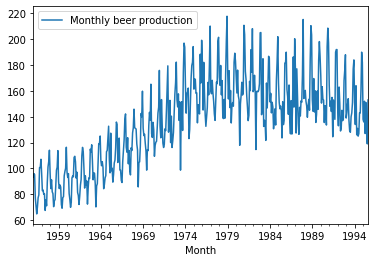

In [3]:
#Aikasarja viivakuviona
df.plot()

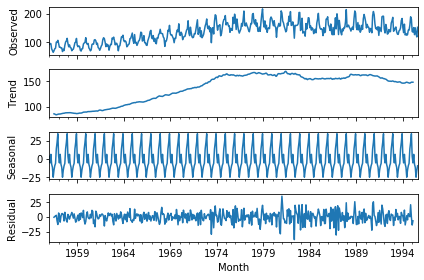

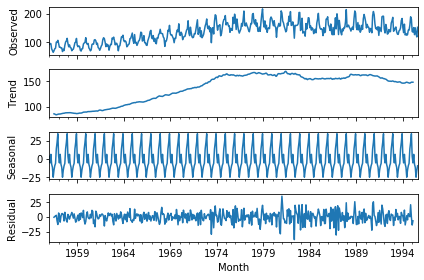

In [4]:
#Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
#Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
#Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

from statsmodels.tsa.api import seasonal_decompose

seasonal_decompose(df['Monthly beer production']).plot()

In [5]:
#Mallin sovitus
from statsmodels.tsa.api import ExponentialSmoothing

#Käytän mallintamiseen Holt-Winterin menetelmää:
#Trendi ja kausivaihtelu huomioidaan
#Kausivaihtelu huomoidaan tulomallina (mul)
malli = ExponentialSmoothing(df['Monthly beer production'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 12).fit()

C:\Users\Henri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [6]:
#malli-olion avulla saadaan mallin mukaan simuloidut ennusteet (fittedvalues)
df['Ennuste'] = malli.fittedvalues
df

,Monthly beer production,Ennuste
Month,,
1956-01-01,93.2,88.528928
1956-02-01,96.0,83.767580
1956-03-01,95.2,92.883851
1956-04-01,77.1,84.471354
1956-05-01,70.9,81.951217
...,...,...
1995-04-01,127.0,136.428754
1995-05-01,151.0,131.269255
1995-06-01,130.0,119.091370


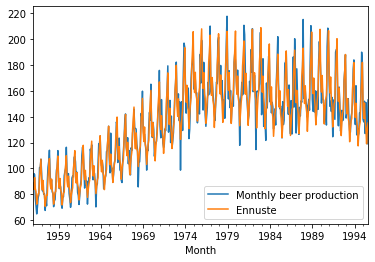

In [7]:
#Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kuvioon
df.plot()

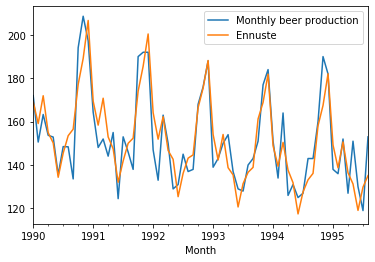

In [8]:
df['1990-01-01':].plot()

In [9]:
#Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Monthly beer production,Ennuste,Ennustevirhe
Month,,,
1956-01-01,93.2,88.528928,4.671072
1956-02-01,96.0,83.767580,12.232420
1956-03-01,95.2,92.883851,2.316149
1956-04-01,77.1,84.471354,-7.371354
1956-05-01,70.9,81.951217,-11.051217
...,...,...,...
1995-04-01,127.0,136.428754,-9.428754
1995-05-01,151.0,131.269255,19.730745
1995-06-01,130.0,119.091370,10.908630


In [10]:
#Mallin hyvyys
from sklearn.metrics import mean_squared_error, mean_absolute_error

#ennustevirheiden neliöiden keskiarvo (MSE = mean squared error)
print('mean squared error', mean_squared_error(df['Monthly beer production'], df['Ennuste']))
#ennustevirheiden itseisarvojen keskiarvo (MAD = mean absolute deviation)
print('mean absolute error', mean_absolute_error(df['Monthly beer production'], df['Ennuste']))

mean squared error 94.8507641051318
mean absolute error 7.357398852624892


Text(0, 0.5, 'Ennustevirhe')

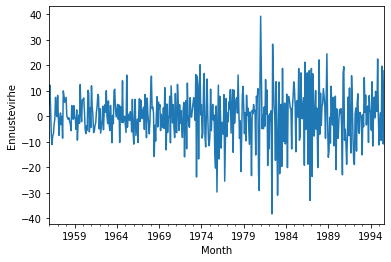

In [11]:
#Ennustevirheet aikasarjana
#On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut')

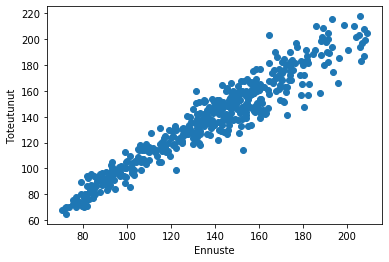

In [12]:
#Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
#vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Monthly beer production'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut')

In [13]:
#Ennusteiden laskeminen seuraavalle vuodelle
periods = 12 #ennustettavien ajankohtien lukumäärä
index = pd.date_range('1995-09-01', #ensimmäisen ennusteen aikaleima
                      periods = periods,
                      freq = 'MS') #ennustettavien ajankohtien frekvenssi, month start frequency (MS)
ennusteet = malli.forecast(periods)

#Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, columns = ['Ennuste'])
df_ennuste

,Ennuste
1995-09-01,139.119273
1995-10-01,161.076469
1995-11-01,171.268387
1995-12-01,183.600359
1996-01-01,150.363509
1996-02-01,141.117582
1996-03-01,153.917500
1996-04-01,139.260271
1996-05-01,135.835600
1996-06-01,121.573591


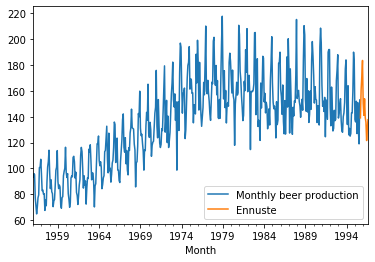

In [14]:
#Viivakuvio havainnoista
df['Monthly beer production'].plot(legend=True)

#Ennusteet kuvioon
df_ennuste['Ennuste'].plot(legend=True)

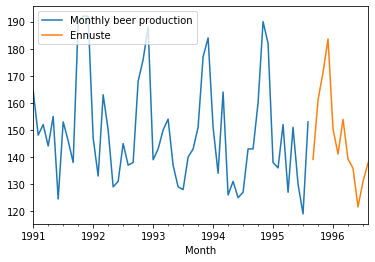

In [15]:
df['Monthly beer production']['1991-01-01':].plot(legend=True)
df_ennuste['Ennuste'].plot(legend=True)

In [16]:
#Ennusteet alkuperäisen aikasarjan perään
df = pd.concat([df, df_ennuste])
df

C:\Users\Henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Ennuste,Ennustevirhe,Monthly beer production
1956-01-01,88.528928,4.671072,93.2
1956-02-01,83.767580,12.232420,96.0
1956-03-01,92.883851,2.316149,95.2
1956-04-01,84.471354,-7.371354,77.1
1956-05-01,81.951217,-11.051217,70.9
...,...,...,...
1996-04-01,139.260271,NaN,NaN
1996-05-01,135.835600,NaN,NaN
1996-06-01,121.573591,NaN,NaN
1996-07-01,130.984850,NaN,NaN


In [17]:
#Mallin statistiikkaa
malli.params

{'smoothing_level': 0.08885840453548413,
 'smoothing_slope': 0.0888574981189868,
 'smoothing_seasonal': 0.02375870961531604,
 'damping_slope': nan,
 'initial_level': 139.5749535260898,
 'initial_slope': 0.09748248027066056,
 'initial_seasons': array([0.63383249, 0.59628287, 0.65125215, 0.58953287, 0.57541456,
        0.51371992, 0.5524196 , 0.5810669 , 0.58488626, 0.67848301,
        0.721594  , 0.77552138]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}